توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path



from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




**solution:**
to solve the problem of black parts after applying changes in the images, we used flags and borderMode options. In addition, the values for displacement, rotation and scaling have been considered fixed numbers not random. Although it will work with random values, this help us to improve the network efficency.

In [ ]:
# function 1
def displacement(img):
  ## To Do
    rows, cols, _ = img.shape
    # dx, dy = np.random.randint(-25, 25, size=2)
    dx, dy = np.array([25,25])

    M = np.float32([[1, 0, dx], [0, 1, dy]])
    displaced_img = cv2.warpAffine(img, M, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_DEFAULT)
    return displaced_img

# function 2
def rotation(img):
    ## To Do
    # angle = np.random.uniform(-30, 30)
    # angle = np.array([30])
    angle = 20

    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_img = cv2.warpAffine(img, M, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_DEFAULT)

    return rotated_img


# # function 3
# def scaling(img):
#   ## To Do
#     # scale_factor = np.random.uniform(0.8, 1.2)
#     # scale_factor = np.array([1.2])
#     scale_factor = 0.7
#     rows, cols, _ = img.shape
#     scaled_img = cv2.resize(img, (int(cols*scale_factor), int(rows*scale_factor)))

#     return scaled_img



def scaling(img):
    # Get the original dimensions of the image
    original_height, original_width = img.shape[:2]

    scale_factor = 1.3

    # Calculate the new dimensions after scaling
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)

    # Use cv2.resize to scale the image
    scaled_img = cv2.resize(img, (new_width, new_height))

    start_row = (new_height - original_height) // 2
    start_col = (new_width - original_width) // 2
    end_row = start_row + original_height
    end_col = start_col + original_width
    scaled_img = scaled_img[start_row:end_row, start_col:end_col]

    return scaled_img





# function 4
def Brightness(img):  ## for augmentation
  ## To Do
    brightness_factor = np.random.uniform(0.5, 2.0)
    bright_img = cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0)

    return bright_img


# function 5
def bluring(img):# for augmentation
  ## To Do
    kernel_size = np.random.choice(range(3, 10, 2))
    blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    return blurred_img


# function 6
def gaussian_noise(img):#for augmentation
  ## To Do
    row, col, ch = img.shape
    gauss = np.random.normal(0, 25, (row, col, ch))
    noisy_img = np.clip(img + gauss, 0, 255).astype(np.uint8)

    return noisy_img




**Solution:**
Here, the point is in __getitem__ function. As you can see, it returns three parameters, the original image corresponds to the index, the transformed version of the image, and also a label that shows which transformations(rotation, scaling, displace) have been applied in a multi-hot vector.

In [ ]:
# class CustomDataset(Dataset):

#     def __init__(self,):
#       ## To Do

#     def __getitem__(self,idx):
#       ## To Do

#     def __len__(self):
#       ## To Do

class CustomDataset(Dataset):

    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        # Read the original image using OpenCV
        original_image = cv2.imread(self.image_paths[idx])

        # Convert the color space from BGR to RGB
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Resize the image to 224x224
        original_image = cv2.resize(original_image, (224, 224))

        # Initialize the label indicating applied transformations (multi-hot)
        applied_transformations = [0, 0, 0]  # [displacement, rotation, scaling]

        # Randomly shuffle the transformation choices
        choices = np.random.permutation([1, 2, 3])[:np.random.randint(1, 4)]  # Choose 1 to 3 random transformations

        # Apply the selected transformations
        transformed_image = original_image.copy()
        for choice in choices:
            if choice == 1:
                transformed_image = displacement(transformed_image)
                applied_transformations[0] = 1
            elif choice == 2:
                transformed_image = rotation(transformed_image)
                applied_transformations[1] = 1
            elif choice == 3:
                transformed_image = scaling(transformed_image)
                applied_transformations[2] = 1

        # Resize the transformed image to 224x224
        transformed_image = cv2.resize(transformed_image, (224, 224))

        # Convert both original and transformed images to PyTorch tensors
        original_image = transforms.ToTensor()(original_image)
        transformed_image = transforms.ToTensor()(transformed_image)

        # Convert the applied_transformations list to a PyTorch tensor
        label = torch.tensor(applied_transformations, dtype=torch.float32)

        # Return a tuple containing the original image, transformed image, and the label
        return original_image, transformed_image, label

    def __len__(self):
        return len(self.image_paths)


**Solution:**
First, we set the train, validation, test paths and then create our CustomDataset from each. Finally, we create dataLoader objects to use in training procedure.

In [ ]:
# dataset_train = CustomDataset()## To Do
# dataset_test = CustomDataset()## To Do
# dataset_val = CustomDataset()## To Do


# train_loader = DataLoader()## To Do
# test_loader= DataLoader()## To Do
# val_loader = DataLoader()## To Do

# File paths for training, testing, and validation sets
train_image_paths = glob.glob("/content/ADEChallengeData2016/images/training/*.jpg")
test_image_paths = glob.glob("/content/release_test/testing/*.jpg")
val_image_paths = glob.glob("/content/ADEChallengeData2016/images/validation/*.jpg")

# Create instances of CustomDataset
dataset_train = CustomDataset(image_paths=train_image_paths)
dataset_test = CustomDataset(image_paths=test_image_paths)
dataset_val = CustomDataset(image_paths=val_image_paths)

# Create DataLoader instances
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=2)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, num_workers=2)


**Solution:**
This cell is going to show four images from train and test datasets with corresponded transformed versions.

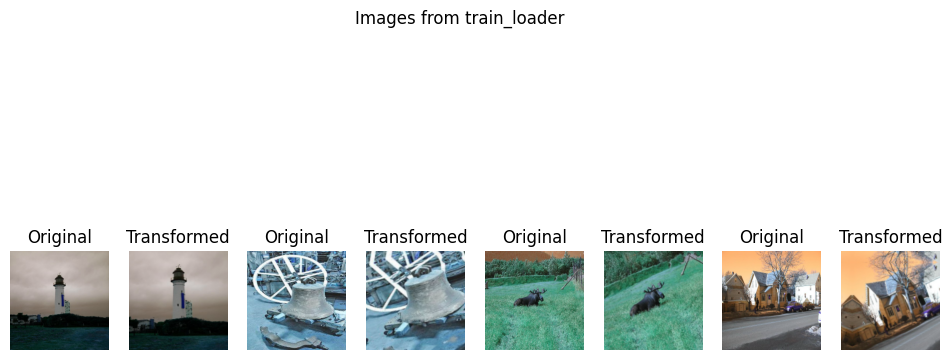

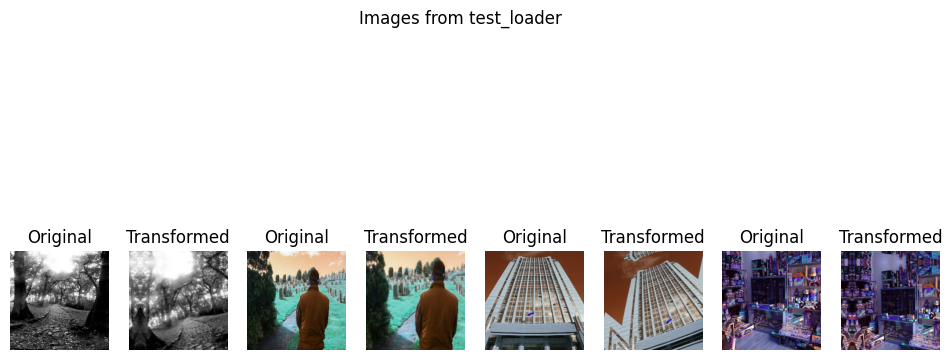

In [ ]:
# ## To Do  : show 8 images from train_loader & 8 images from test_loader

# # Function to display images using cv2
# def show_images_cv(images, title):
#     num_images = images.shape[0]
#     cols = 4
#     rows = (num_images + cols - 1) // cols

#     plt.figure(figsize=(12, 6))
#     plt.suptitle(title)

#     for i in range(num_images):
#         plt.subplot(rows, cols, i + 1)
#         plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
#         plt.axis("off")

#     plt.show()


# # Get 8 images from train_loader
# train_data_iter = iter(train_loader)
# train_images, _, _ = next(train_data_iter)

# # Get 8 images from test_loader
# test_data_iter = iter(test_loader)
# test_images, _ ,_= next(test_data_iter)

# # Convert PyTorch tensor images to NumPy arrays for display
# train_images_np = (train_images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
# test_images_np = (test_images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)

# # Show 8 images from train_loader
# show_images_cv(train_images_np[:8], "Images from train_loader")

# # Show 8 images from test_loader
# show_images_cv(test_images_np[:8], "Images from test_loader")



# Function to display original and transformed images using cv2
def show_original_and_transformed_images(images, transformed_images, title):
    num_images = images.shape[0]
    cols = 4
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    for i in range(num_images):
        plt.subplot(rows, 2 * cols, 2 * i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Original")

        plt.subplot(rows, 2 * cols, 2 * i + 2)
        plt.imshow(cv2.cvtColor(transformed_images[i], cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Transformed")

    plt.show()

# Get 4 images with transformations from train_loader
train_data_iter = iter(train_loader)
train_original_images, train_transformed_images, labels = next(train_data_iter)

# print(labels)

# Get 4 images with transformations from test_loader
test_data_iter = iter(test_loader)
test_original_images, test_transformed_images, _ = next(test_data_iter)

# Convert PyTorch tensor images to NumPy arrays for display
train_original_images_np = (train_original_images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
train_transformed_images_np = (train_transformed_images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)

test_original_images_np = (test_original_images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
test_transformed_images_np = (test_transformed_images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)

# Show 4 original and transformed images from train_loader
show_original_and_transformed_images(train_original_images_np[:4], train_transformed_images_np[:4], "Images from train_loader")

# Show 4 original and transformed images from test_loader
show_original_and_transformed_images(test_original_images_np[:4], test_transformed_images_np[:4], "Images from test_loader")


##Model

**`در`** این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

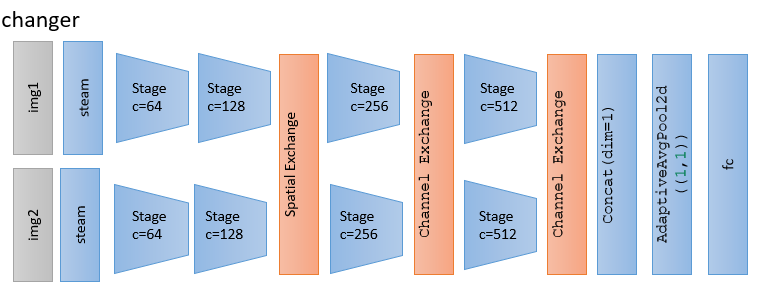

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


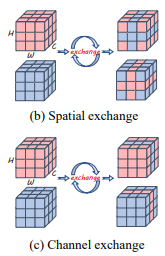

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

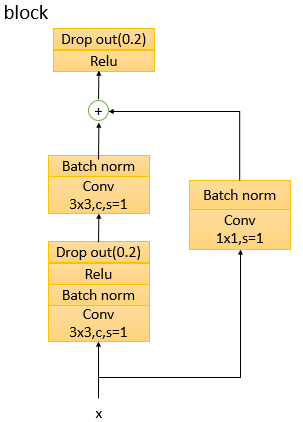

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟

کانولوشن یک در یک در واقع تنها در طول کانال اثر میکند و نقش کاهش بعد را بازی میکند.



In [ ]:
# ##To Do
# class block(nn.Module):
#   def __init__(self,):
#     super(block,self).__init__()


#   def forward(self,x):


#     return out

class Block(nn.Module):
    def __init__(self, in_channels=64, c=64):
        super(Block, self).__init__()

        # Right path: 1x1 Convolution and Batch Normalization
        self.right_path = nn.Sequential(
            nn.Conv2d(in_channels, c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(c)
        )

        # Left path: Two 3x3 Convolutions with Batch Normalization and ReLU
        self.left_path = nn.Sequential(
            nn.Conv2d(in_channels, c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c)
        )

        # Final ReLU and Dropout
        self.final_relu_dropout = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )

    def forward(self, x):
        # print('b')
        # Forward pass for both paths
        left_output = self.left_path(x)
        right_output = self.right_path(x)

        # Sum the outputs of the two paths
        out = left_output + right_output

        # Apply final ReLU and Dropout
        out = self.final_relu_dropout(out)

        return out

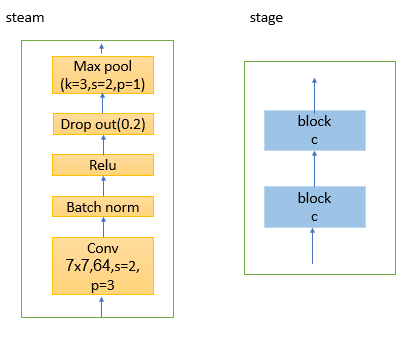

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
class changer(nn.Module):
    def __init__(self, block, SpatialExchange, ChannelExchange):
        super(changer, self).__init__()

        self.in_channels = 3  # Update with the actual number of input channels

        self.stream = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stage1 = self._make_stage(block, 64, 64)
        self.stage2 = self._make_stage(block, 128, 64)
        self.spatial_exchange = SpatialExchange()
        self.stage3 = self._make_stage(block, 256, 128)
        self.channel_exchange1 = ChannelExchange()
        self.stage4 = self._make_stage(block, 512, 256)
        self.channel_exchange2 = ChannelExchange()
        # Adding a fully connected layer with size 1024 * 3
        self.fc = nn.Linear(1024, 3)


    def _make_stage(self, block, out_channels, in_channels):
        layers = [
            block(in_channels, out_channels),
            block(out_channels, out_channels)
        ]
        self.in_channels = out_channels  # Update in_channels for the next stage
        return nn.Sequential(*layers)


    def forward(self, x1, x2):
        stream_out1 = self.stream(x1)
        stream_out2 = self.stream(x2)
        stage1_out1 = self.stage1(stream_out1)
        stage1_out2 = self.stage1(stream_out2)
        stage2_out1 = self.stage2(stage1_out1)
        stage2_out2 = self.stage2(stage1_out2)

        sp_ex_out1, sp_ex_out2 = self.spatial_exchange(stage2_out1, stage2_out2)

        stage3_out1 = self.stage3(sp_ex_out1)
        stage3_out2 = self.stage3(sp_ex_out2)
        ch_ex1_out1, ch_ex1_out2 = self.channel_exchange1(stage3_out1, stage3_out2)

        stage4_out1 = self.stage4(ch_ex1_out1)
        stage4_out2 = self.stage4(ch_ex1_out2)

        ch_ex2_out1,ch_ex2_out2 = self.channel_exchange2(stage4_out1,stage4_out2)

        # Concatenate along the channel dimension
        concatenated = torch.cat([ch_ex2_out1, ch_ex2_out2], dim=1)

        # Global Average Pooling
        pooled = nn.functional.adaptive_avg_pool2d(concatenated, (1, 1))

        # Flatten and pass through fully connected layer
        flt = pooled.view(pooled.size(0), -1)

        out = self.fc(flt)

        return out


In [ ]:
## To Do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model=changer(Block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.BCELoss() ## loss
optimizer = optim.Adam(model.parameters(), lr=0.001) ## optimizer

##Train & validation


In [1]:
Loss_train=[]
Loss_val=[]

# print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

num_epochs = 5


# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss_train = 0.0
    correct_train = 0
    total_samples_train = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        data1, data2, target = data1.to(device), data2.to(device), target.to(device)

        # Forward pass
        output = model(data1, data2)

        # Compute the loss
        loss = citeration(output, target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Update the training metrics
        total_loss_train += loss.item()

        print(f'output: {output}')
        # Apply a threshold to convert logits to binary predictions
        predicted = torch.sigmoid(output) > 0.5
        print(f'predicted: {predicted}')


        correct_train += (predicted == target).sum().item()
        total_samples_train += target.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss_train = total_loss_train / len(train_loader)
    accuracy_train = correct_train / total_samples_train

    # Append the values to the lists for visualization or further analysis
    Loss_train.append(avg_loss_train)

    # Print the current epoch's results
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train: {avg_loss_train:.3f}, Acc_train: {accuracy_train:.3f}')





# After the training loop, print the final results
print(f'Final results - Loss_train: {avg_loss_train:.3f}, Acc_train: {accuracy_train:.3f}')



#Test


In [ ]:
checkpoint = torch.load('#To Do')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test

print(f' loss_test= {:.3f}, acc_test={()}')


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟